# Film Analysis
This is a project for the IUM course of the computer science degree course.  
This project wants to analyse and visualize some data like the actors, the languages, the crew exc. of different films. 
## First steps
In the beginning we check the type of the data of the dataframes used for the analysis, later we will clean the data so that we can start the analysis of them in order to find some correlation between the data or to debunking common beliefs.  
In this notebook there will be some visualisations, these visualisations are intended to point out some characteristics of the data that I'm going to analyse    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium import Choropleth, GeoJson, GeoJsonTooltip
from utils.functions import classifica_durata, status_oscars, normalize_review

In [2]:
actors = pd.read_csv('data/actors.csv')
countries = pd.read_csv('data/countries.csv')
crew = pd.read_csv('data/crew.csv')
genres = pd.read_csv('data/genres.csv')
languages = pd.read_csv('data/languages.csv')
movies = pd.read_csv('data/movies.csv') #contiene anche film che devono ancora uscire e che quindi non hanno ancora un rating
releases = pd.read_csv('data/releases.csv')
rotten_tomatoes = pd.read_csv('data/rotten_tomatoes_reviews.csv')
studios = pd.read_csv('data/studios.csv')
oscars = pd.read_csv('data/the_oscar_awards.csv')

In [3]:
actors['name'] = actors['name'].astype('string')
actors['role'] = actors['role'].astype('string')
countries['country'] = countries['country'].astype('string')
crew['name'] = crew['name'].astype('string')
crew['role'] = crew['role'].astype('string')
genres['genre'] = genres['genre'].astype('string')
languages['language'] = languages['language'].astype('string')
languages['type'] = languages['type'].astype('string')
movies['name'] = movies['name'].astype('string')
releases['country'] = releases['country'].astype('string')
releases['type'] = releases['type'].astype('string')
releases['date'] = pd.to_datetime(releases['date'], format='%Y-%m-%d')
studios['studio'] = studios['studio'].astype('string')
oscars['category'] = oscars['category'].astype('string')
oscars['name'] = oscars['name'].astype('string')
oscars['film'] = oscars['film'].astype('string')
oscars['winner'] = oscars['winner'].astype(bool)
rotten_tomatoes['movie_title'] = rotten_tomatoes['movie_title'].astype('string')
rotten_tomatoes['critic_name'] = rotten_tomatoes['critic_name'].astype('string')
rotten_tomatoes['publisher_name'] = rotten_tomatoes['publisher_name'].astype('string')
rotten_tomatoes['review_score'] = rotten_tomatoes['review_score'].astype('string')
rotten_tomatoes['review_date'] = pd.to_datetime(rotten_tomatoes['review_date'], format='%Y-%m-%d')

In [9]:
dataframes = {'df1': actors, 'df2': countries, 'df3': crew, 'df4': genres, 'df5': languages, 'df6': movies,
              'df7': releases, 'df8': studios, 'df9': oscars, 'df10': rotten_tomatoes}

for name, df in dataframes.items():
    print(f"{name} columns:")
    print(list(df.columns))
    print()

df1 columns:
['id', 'name', 'role']

df2 columns:
['id', 'country']

df3 columns:
['id', 'role', 'name']

df4 columns:
['id', 'genre']

df5 columns:
['id', 'type', 'language']

df6 columns:
['id', 'name', 'date', 'tagline', 'description', 'minute', 'rating']

df7 columns:
['id', 'country', 'date', 'type', 'rating']

df8 columns:
['id', 'studio']

df9 columns:
['year_film', 'year_ceremony', 'ceremony', 'category', 'name', 'film', 'winner']

df10 columns:
['rotten_tomatoes_link', 'movie_title', 'critic_name', 'top_critic', 'publisher_name', 'review_type', 'review_score', 'review_date', 'review_content']



# Highest Rating Films per Country
This analysis aims to visualize the average rating of films produced by countries with at least 1,500 films.  
Since the United States produces the most films overall and is the most renowned for its film production, it is expected to have the highest average rating.  
The majority of award-winning films are produced in America, so it's natural to assume that the average rating for these films would also be higher than elsewhere.  
However, this isn't the case; among all the countries that have produced at least 1,500 films, the one with the highest average rating is Japan, followed by France and England (America isn't even on the podium). This holds true even if we raise the minimum threshold of films to 5,000, America remains outside the top three.  
The number of films produced by every nation is shown by the piechart where the countries wth less than 850 films are grouped in the label "Others"

In [7]:
country_films = pd.merge(movies, countries, left_on='id', right_on='id', how='left')

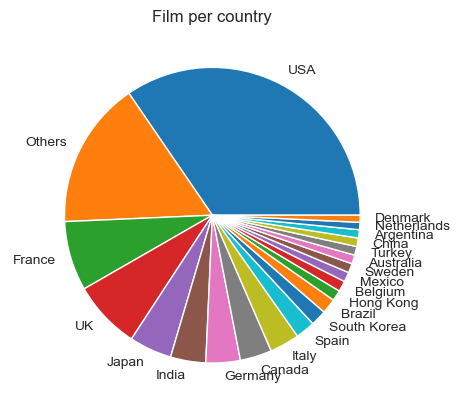

In [8]:
country_films = country_films[~country_films['rating'].isna()]
counts_of_films = country_films['country'].value_counts()
valid_countries = counts_of_films[counts_of_films >= 850].index

country_films['country_grouped'] = country_films['country'].where(
    country_films['country'].isin(valid_countries),
    other='Others'
)

counts = country_films['country_grouped'].value_counts()
counts.plot(kind='pie')
plt.title('Film per country')
plt.ylabel(' ')
plt.show()

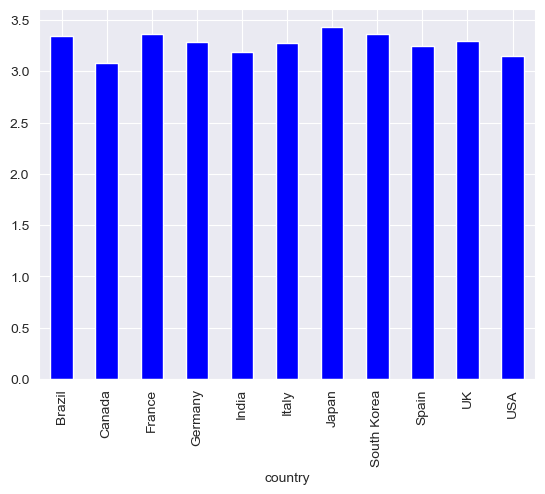

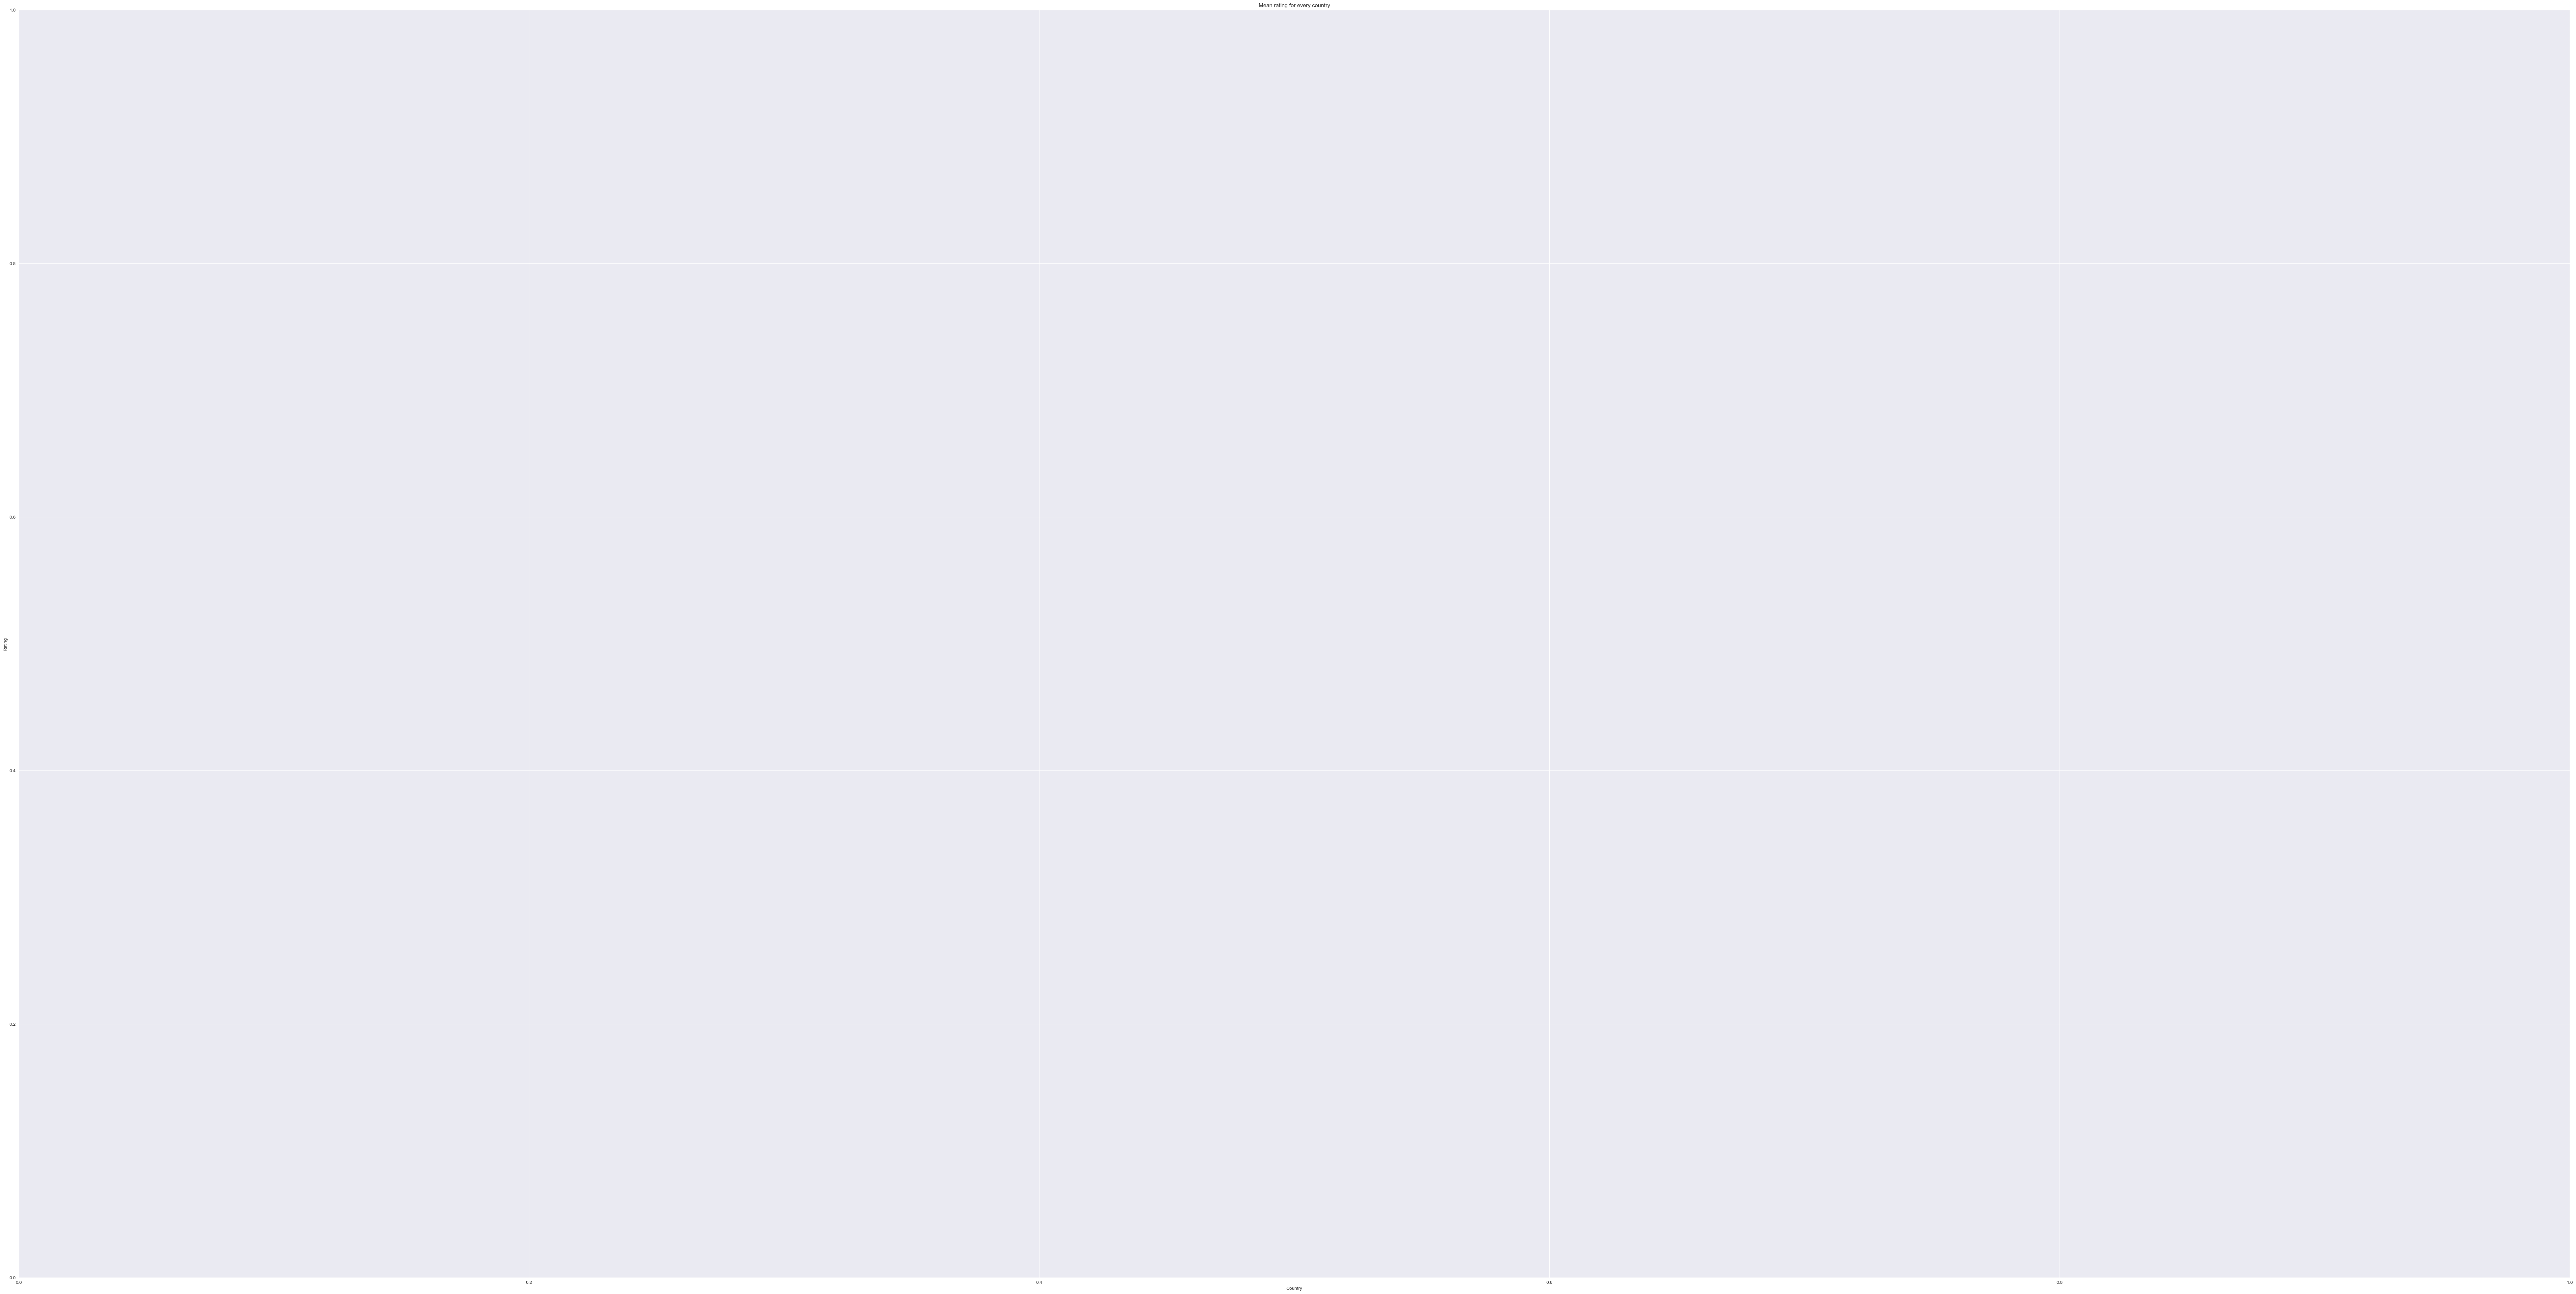

In [9]:
country_with1500_films = counts_of_films[counts_of_films > 1500].index
country_top1500 = country_films[country_films['country'].isin(country_with1500_films)]
avg_rating_by_country = country_top1500.groupby('country')['rating'].mean()
avg_rating_by_country = avg_rating_by_country[avg_rating_by_country > 2.5]
avg_rating_by_country.plot(kind='bar', color='blue')
plt.xticks(rotation=90)
plt.figure(figsize=(100, 50))
plt.title('Mean rating for every country')
plt.xlabel('Country')
plt.ylabel('Rating')
plt.show()

# TrendLine of the production of films by year
For this analysis, we only consider films produced up to 2023 because in the "movie" dataset, some films produced in 2024 have a rating while others do not.  
This suggests that some films have not yet been released and will not be included in the analysis because it is uncertain whether they will be produced, just as the release year is uncertain; many films are often postponed  
As we can expect the production of the films from 1874 has exponentially increased thanks to some innovations in the cinematography world, for example, in 1996, high definition was introduced, an international agreement on resolution and format standards.  
Another innovation occurred in 1999 when the first non-experimental film was released with large portions shot with high-definition cameras. Computer editing also made film production faster

In [10]:
films_by_year = pd.merge(movies, countries, on='id', how='left')
# eliminate the duplicated films with same release year
films_by_year.drop_duplicates(subset=['id', 'date'] ,inplace=True)
films_by_year = films_by_year[films_by_year['date'] < 2024]
films_by_year['date'].describe()

count    830290.000000
mean       1997.926545
std          27.574031
min        1874.000000
25%        1985.000000
50%        2009.000000
75%        2018.000000
max        2023.000000
Name: date, dtype: float64

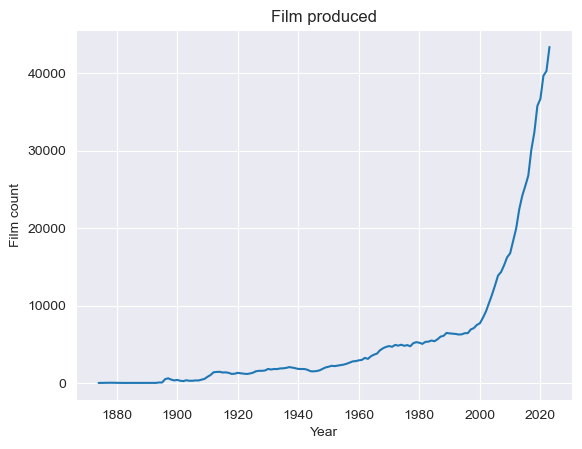

In [11]:
trend = films_by_year.groupby('date').size().reset_index(name = 'film_count')
# build the trendLine
sns.lineplot(data=trend, x='date', y='film_count')
plt.title('Film produced')
plt.xlabel('Year')
plt.ylabel('Film count')
plt.grid(True)
plt.show()

In [12]:
#~

# Rating VS Film Length
This analysis aimed to identify a possible correlation between film length and ratings.  
By observing the various values for each film's running time, I realized that the dataset includes not only films but also TV series, looking more carefully, thanks to the visualization of distribution of the movies that weren't series, i noticed that there also were short films. This led me to first divide the three types of movies into three categories, based on their running time, typically between 60 and 240 minutes.  
After this, I initially attempted to visualize a possible correlation between the three categories and their running time on the same chart, but this did not yield any conclusions. I subsequently attempted to visualize the possible correlations for each category individually, but again without success.  
We can therefore say that the running time of films, short films, and TV series does not impact the final rating.

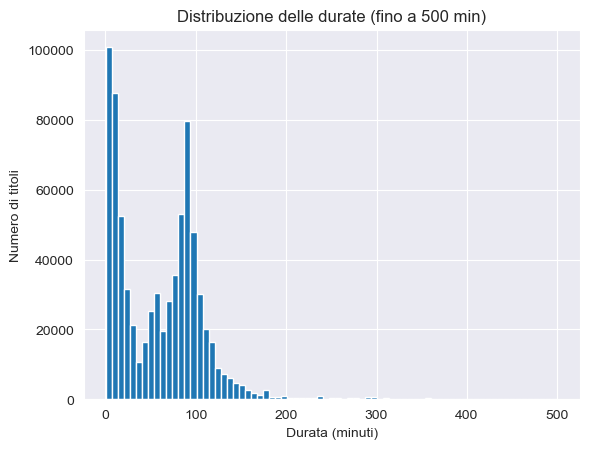

In [13]:
movies_filtered = movies[movies['minute'] <= 500]
movies_filtered = movies_filtered[movies_filtered['minute'].notna()]
plt.hist(movies_filtered['minute'], bins=75)
plt.xlabel('Durata (minuti)')
plt.ylabel('Numero di titoli')
plt.title('Distribuzione delle durate (fino a 500 min)')
plt.show()

In [14]:
movies_with_types = movies
movies_with_types['type_of_movie'] = movies_with_types.apply(classifica_durata, axis=1)

In [15]:
movies_with_types = movies_with_types[(movies_with_types['rating'].notna()) & (movies['minute'].notna())]

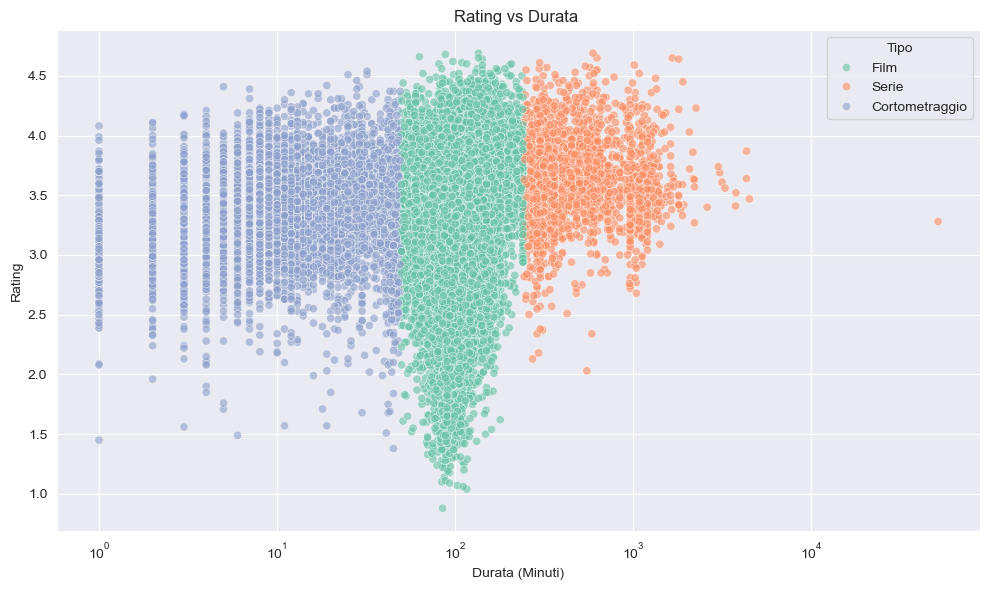

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=movies_with_types,
    x='minute',
    y='rating',
    hue='type_of_movie',
    palette='Set2',
    alpha=0.6
)
plt.xscale('log')  # Scala logaritmica
plt.title('Rating vs Durata ')
plt.xlabel('Durata (Minuti)')
plt.ylabel('Rating')
plt.legend(title='Tipo')
plt.tight_layout()
plt.show()

In [17]:
films = movies[movies['type_of_movie'] == 'Film']
series = movies[movies['type_of_movie'] == 'Serie']
corto = movies[movies['type_of_movie'] == 'Cortometraggio']

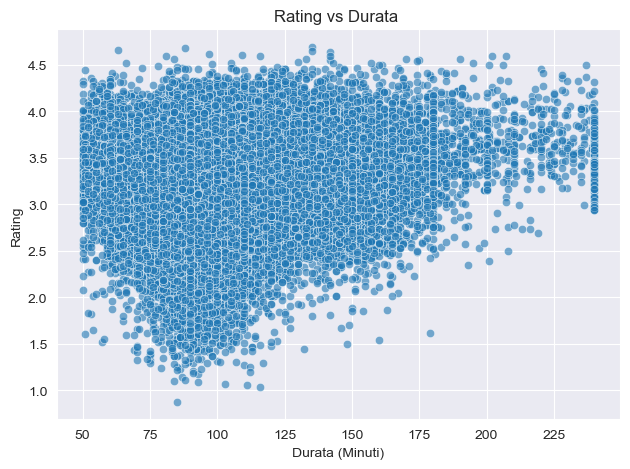

In [18]:
sns.scatterplot(
    data=films,
    x='minute',
    y='rating',
    alpha=0.6
)
plt.title('Rating vs Durata ')
plt.xlabel('Durata (Minuti)')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

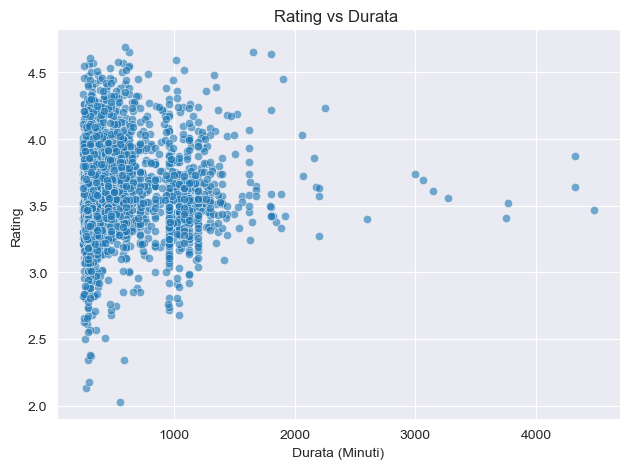

In [19]:
series = series[series['minute']<20000]
sns.scatterplot(
    data=series,
    x='minute',
    y='rating',
    alpha=0.6
)
plt.title('Rating vs Durata ')
plt.xlabel('Durata (Minuti)')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

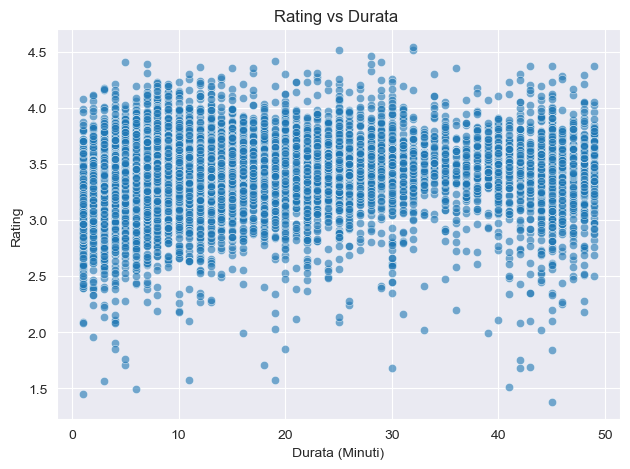

In [20]:
sns.scatterplot(
    data=corto,
    x='minute',
    y='rating',
    alpha=0.6
)
plt.title('Rating vs Durata ')
plt.xlabel('Durata (Minuti)')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

# Oscar-nominated Films
It's common to think that films with nominations or films that has won an oscar have a far higher rating than the others. Well, that's not completely true.  
You're right if you think that the average ratings for the films with at least one nomination is higher than the other ones but the difference between them is very subtle.  
This analysis shows that, after having separated the three types of movies (nominated, not nominated and winners) and calculated the mean's rating for every category, remember that we have previously said that in the movies dataset there are film, short film and series, the chart shows us that yes, there's a difference between the rating of the movies nominated at the oscars, not nominated and the winners one, but the differences is very small.  
This could mean either that the selection of Oscar-nominated films is very difficult because they are all considered valid or it is very difficult because there are not many films that excel above others.  
The real difference is shown when you analyze just Oscar-winning films and the ones which have not even been nominated, here the difference is marked of course  
p.s. for the series we had just one record that has won an oscar award so the analysis for the series isn't effective but i kept it anyway

In [21]:
movies_2 = movies
oscars.loc[oscars['film'].notna(), 'nominated'] = True
oscars['nominated'] = oscars['nominated'].astype(bool)
oscars['film'] = oscars['film'].str.lower()
oscars_2 = oscars.dropna(subset=['film']) 
# Delete Nan in the film column 
movies_2['name'] = movies_2['name'].str.lower()

# Drop duplicates where there are different nominations for the same film
nominations = oscars_2.drop_duplicates(subset=['year_film', 'film'])
# Rename column for the merge
movies_2 = movies_2.rename(columns={'name': 'film_name'})
movies_2 = movies_2[movies_2['rating'].notna()]
oscar_films = pd.merge(movies_2, nominations, left_on=['film_name', 'date'], right_on=['film', 'year_film'], how='left')
oscar_films['nominated'] = np.where(oscar_films['nominated'].isna(), False, True)
oscar_films['oscar_status'] = oscar_films.apply(status_oscars, axis=1)

In [34]:
rating_by_nominations = oscar_films.groupby(['type_of_movie' ,'oscar_status'])['rating'].mean().unstack()
oscar_films = oscar_films[(oscar_films['oscar_status'] == 'Vincitore') | (oscar_films['oscar_status'] == 'Non nominato')]

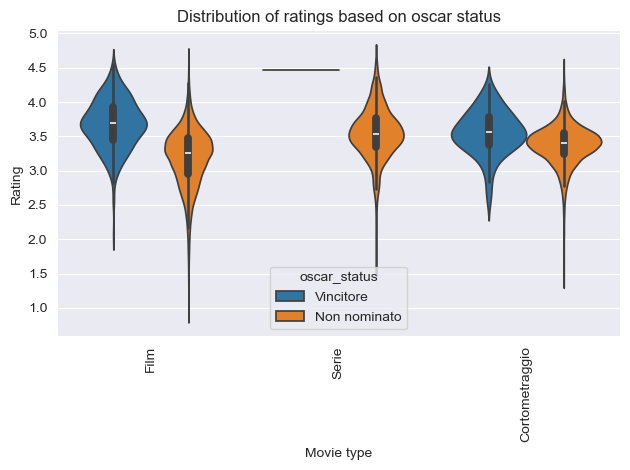

In [35]:
sns.violinplot(data=oscar_films, x='type_of_movie', y='rating', hue='oscar_status')
plt.title('Distribution of ratings based on oscar status')
plt.xticks(rotation=90)
plt.xlabel('Movie type')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

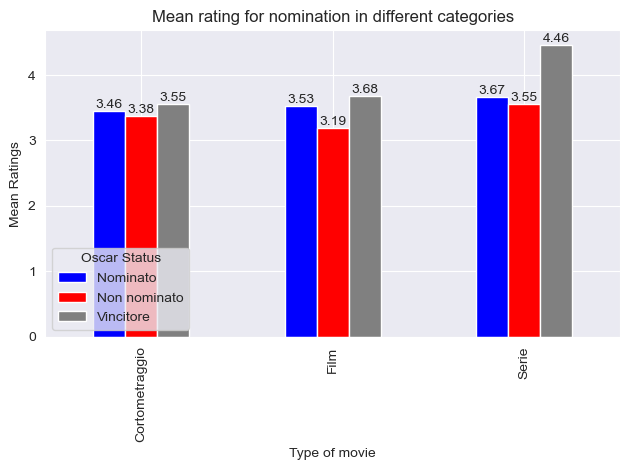

In [22]:
ax = rating_by_nominations.plot(kind='bar', color=['blue', 'red', 'gray'])
plt.title('Mean rating for nomination in different categories')
plt.ylabel('Mean Ratings')
plt.xlabel('Type of movie')
plt.legend(title='Oscar Status')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
plt.tight_layout()
plt.show()

# Directors & Genres
We have taken the first 10 directors with the most amount of films and tried to see if there's some correlation between the genres of their films, and the mean of the ratings for every genre.  
Maybe this analyse could show us some genres that, for some directors, are preferred, everybody knows that if you do something that you like it turns out better than the ones you doesn't like to do.  
But it can also show us if someone has a bad rating in every genre, for example we can see that the director Alexandre Promio is not doing very well in almost every movie he made.  
On the other and Dave Fleischer did a good job on average on every movie he produced for different genres, so we can say that he is an all around director, he's not excellent in any category, but he's good in everyone  
There are also some directors that are good in some category and not so good in others, for example William Hanna is a pretty good director for Drama or Music movies because he has, on average, a solid 3.7 rating, while when he made science-fiction movies he barely gets a 2.8

In [23]:
valid_movies = movies[(movies['rating'].notna()) & (movies['date'] < 2024)]
valid_crew = crew[(crew['name'].notna()) & (crew['role'] == 'Director')]
director_movies = pd.merge(movies, valid_crew, on='id', how='inner')
genre_movies = pd.merge(director_movies, genres, on='id', how='inner')
genre_movies.rename(columns={'name_y': 'cast_name'}, inplace=True)
genre_movies.rename(columns={'name_x': 'film_name'}, inplace=True)

In [24]:
g_m_view = genre_movies[['id', 'film_name', 'rating', 'type_of_movie', 'cast_name', 'genre']]
valid_director = g_m_view['cast_name'].value_counts()
top10_director_movies = valid_director.head(10).index
top10_director_movies = g_m_view[g_m_view['cast_name'].isin(top10_director_movies)]

In [25]:
pivot_table = top10_director_movies.pivot_table(
    index='cast_name',
    columns='genre',
    values='rating',
    aggfunc='mean'
)   

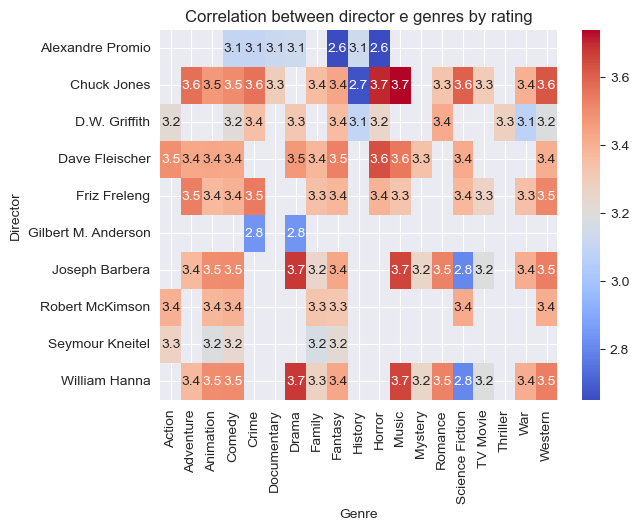

<Figure size 1600x1100 with 0 Axes>

In [26]:
sns.heatmap(data=pivot_table, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Correlation between director e genres by rating')
plt.xlabel('Genre')
plt.ylabel('Director')
plt.xticks(rotation=90)
plt.figure(figsize=(16, 11))
plt.show()

# Let's do Geographic
WHY NOT?  
I wanted to try a geographical visualisation so bad, so here we are.  
This map show us how many film every country in europe has produced; the map is very simple, but it's evocative. In europe the main producers of films are Germany, France and England, followed by Italy, Spain and Sweden.  
I think that no one knows that sweden has made over 8000 movies 

In [27]:
world = gpd.read_file('data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
europe = world[world['CONTINENT'] == 'Europe']
america = world[(world['CONTINENT'] == 'North America') | (world['CONTINENT'] == 'South America')]
asia = world[world['CONTINENT'] == 'Asia']
africa = world[world['CONTINENT'] == 'Africa']

C:\Users\marco\miniconda3\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


In [28]:
geo_movies = pd.merge(movies, countries, on='id', how='inner')
geo_movies = geo_movies[geo_movies['date'] < 2024]
geo_movies.loc[geo_movies['country'] == 'UK', 'country'] = 'United Kingdom'
geo_movies.loc[geo_movies['country'] == 'Russian Federation', 'country'] = 'Russia'
geo_movies.loc[geo_movies['country'] == 'Bosnia and Herzegovina', 'country'] = 'Bosnia and Herz.'
geo_movies.loc[geo_movies['country'] == 'Republic of Moldova', 'country'] = 'Moldova'
#geo_movies.loc[geo_movies['country'] == 'USA', 'country'] = 'United States of America'

In [29]:
euro_movies = pd.merge(geo_movies, europe, left_on='country', right_on='NAME', how='inner')
euro_counts = euro_movies.groupby('country')['id'].count().reset_index()
euro_counts.columns = ['name', 'film_count']

# Final merge to have the geometry of the states and to do the geographic chart
europe_map = pd.merge(europe, euro_counts, left_on='NAME', right_on='name', how='left')
europe_map['film_count'] = europe_map['film_count'].fillna(0)

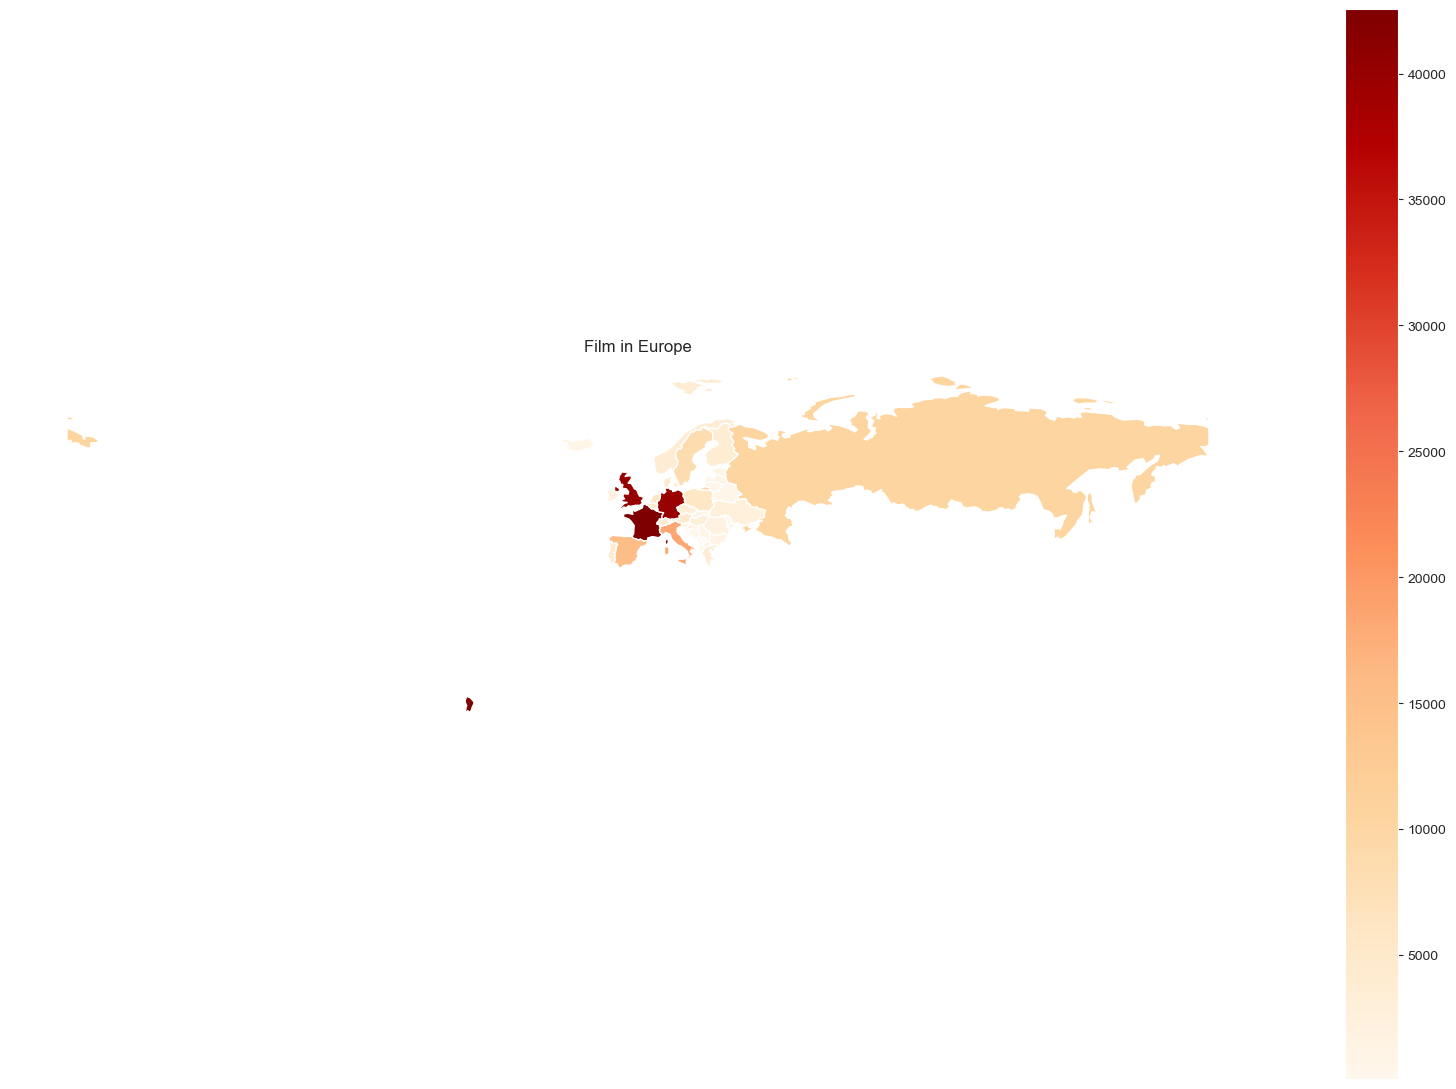

In [30]:
fig, ax = plt.subplots(figsize=(16, 11))
europe_map.plot(column='film_count', cmap='OrRd', legend=True, ax=ax)
plt.title('Film in Europe')
plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
# Crea la mappa centrata sull'Europa
m = folium.Map(location=[54, 15], zoom_start=4, tiles='CartoDB Positron')

# Aggiungi la mappa coropletica
Choropleth(
    geo_data=europe_map.__geo_interface__,
    data=europe_map,
    columns=['NAME', 'film_count'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Numero di film prodotti'
).add_to(m)

# Aggiungi tooltip interattivo
GeoJson(
    europe_map.__geo_interface__,
    tooltip=GeoJsonTooltip(
        fields=['NAME', 'film_count'],
        aliases=['Paese:', 'Film prodotti:'],
        localize=True,
        sticky=False
    )
).add_to(m)
m

# Most productive Studios
This time I wanted to analyse the studios, to see which studio have produced the most number of movies and what is the mean duration of the movies produced by them.  
So I divided the movies by the type (films, short films and series), counted for every category how many movies they've made and the mean duration of the movies of every studio. It turns out that for the films the BBC is the most productive studio and its films has a mean duration of over an hour and a half (showed by the size of the bubble).  
If we look at the Short Films instead, we can see that the studios with the most number of movies is ONF|NFB, in this case the mean duration is pretty above the others. It is worth nothing that also in this chart there is "Warner Bros. Pictures", it's in the top 5 both in film and Short Films, they're pretty consistent in the Films Industry.  
Moving on to the Series chart we find "Studio Dragon" as the most productive studio, followed by the BBC, that is first in the film production.  
This complete difference between the chart (except for the two studios that appear in 2 of the 3 charts) could mean that after the explosion of the film industry, dominate by the main company like Warner bros, BBC, Paramount, Columbia, Universal and others, some company have managed to find their own spaces between the Bigs and they find a way to be competitive, if not in the film industry in the Series and Short Films one 

In [37]:
studio_movies = pd.merge(movies, studios, on='id', how='inner')
studio_movies = studio_movies[(studio_movies['date'] < 2024) & (studio_movies['minute'].notna())]
studio_movies['type_of_movie'] = studio_movies.apply(classifica_durata, axis=1)
studio_films = studio_movies[studio_movies['type_of_movie'] == 'Film']
studio_corto = studio_movies[studio_movies['type_of_movie'] == 'Cortometraggio']
studio_series = studio_movies[studio_movies['type_of_movie'] == 'Serie']

In [38]:
top_5_film_studios = studio_films.groupby('studio')['id'].count().sort_values(ascending=False).head(5).index
studio_films = studio_films[studio_films['studio'].isin(top_5_film_studios)]
studio_films_duration = studio_films.groupby('studio').agg(film_count=('id', 'count'), avg_duration=('minute', 'mean')).reset_index()

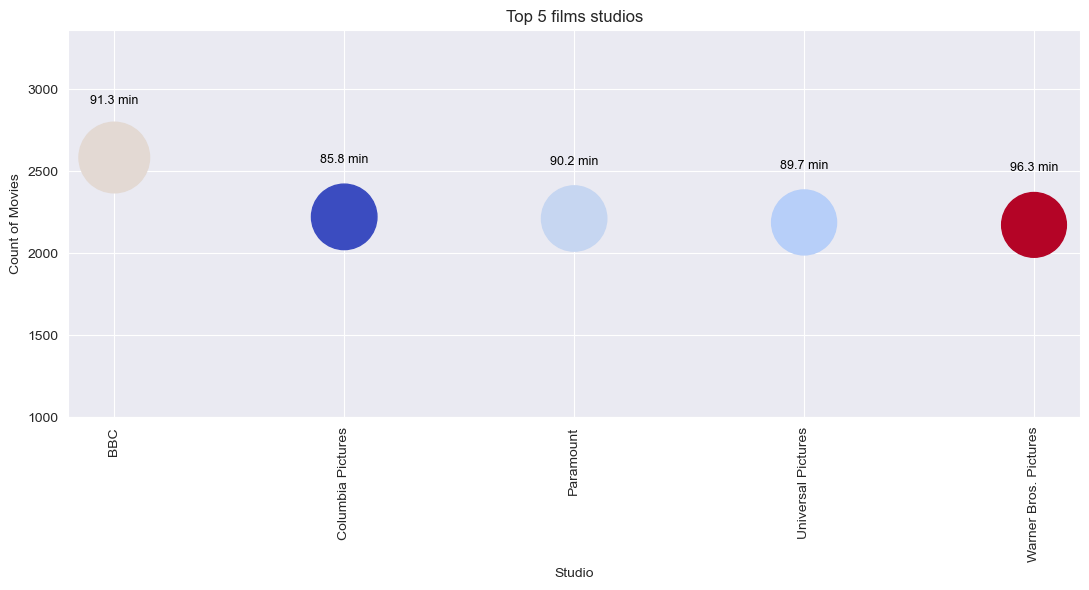

In [63]:
plt.figure(figsize=(11, 6))
plt.scatter(
    x=studio_films_duration['studio'],
    y=studio_films_duration['film_count'],
    s=studio_films_duration['film_count'],
    c=studio_films_duration['avg_duration'],
    cmap='coolwarm'
)
for i in range(len(studio_films_duration)):
    plt.text(
        studio_films_duration['studio'][i],
        studio_films_duration['film_count'][i] + 0.12 * studio_films_duration['film_count'].max(),  # leggermente sopra la bolla
        f"{studio_films_duration['avg_duration'][i]:.1f} min",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
    
plt.title('Top 5 films studios')
plt.xticks(rotation=90)
plt.xlabel('Studio')
plt.ylabel('Count of Movies')
plt.ylim(1000, studio_films_duration['film_count'].max()* 1.3)
plt.tight_layout()
plt.show() 

In [56]:
top_5_corto_studios = studio_corto.groupby('studio')['id'].count().sort_values(ascending=False).head(5).index
studio_corto = studio_corto[studio_corto['studio'].isin(top_5_corto_studios)]
studio_corto_duration = studio_corto.groupby('studio').agg(corto_count=('id', 'count'), avg_duration=('minute', 'mean')).reset_index()

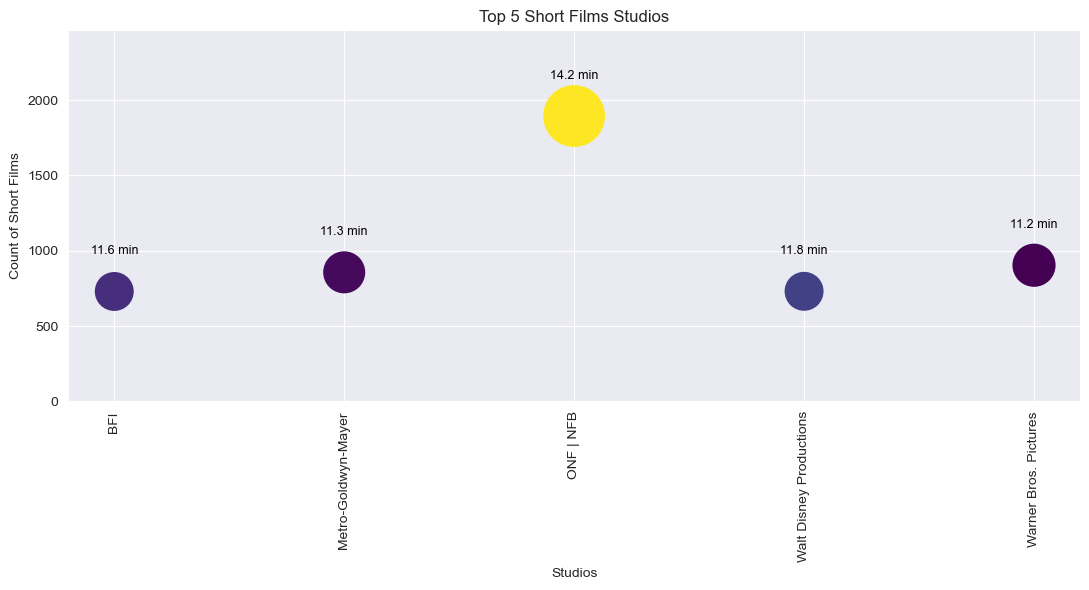

In [62]:
plt.figure(figsize=(11, 6))
plt.scatter(
    x=studio_corto_duration['studio'],
    y=studio_corto_duration['corto_count'],
    s=studio_corto_duration['corto_count'],
    c=studio_corto_duration['avg_duration'],
    cmap='viridis'
)
for i in range(len(studio_corto_duration)):
    plt.text(
        studio_corto_duration['studio'][i],
        studio_corto_duration['corto_count'][i] + 0.12 * studio_corto_duration['corto_count'].max(),  # leggermente sopra la bolla
        f"{studio_corto_duration['avg_duration'][i]:.1f} min",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
    
plt.title('Top 5 Short Films Studios')
plt.xticks(rotation=90)
plt.xlabel('Studios')
plt.ylabel('Count of Short Films')
plt.ylim(0, studio_corto_duration['corto_count'].max()* 1.3)
plt.tight_layout()
plt.show() 

In [49]:
top_5_series_studios = studio_series.groupby('studio')['id'].count().sort_values(ascending=False).head(5).index
studio_series = studio_series[studio_series['studio'].isin(top_5_series_studios)]
studio_series_duration = studio_series.groupby('studio').agg(series_count=('id', 'count'), avg_duration=('minute', 'mean')).reset_index()

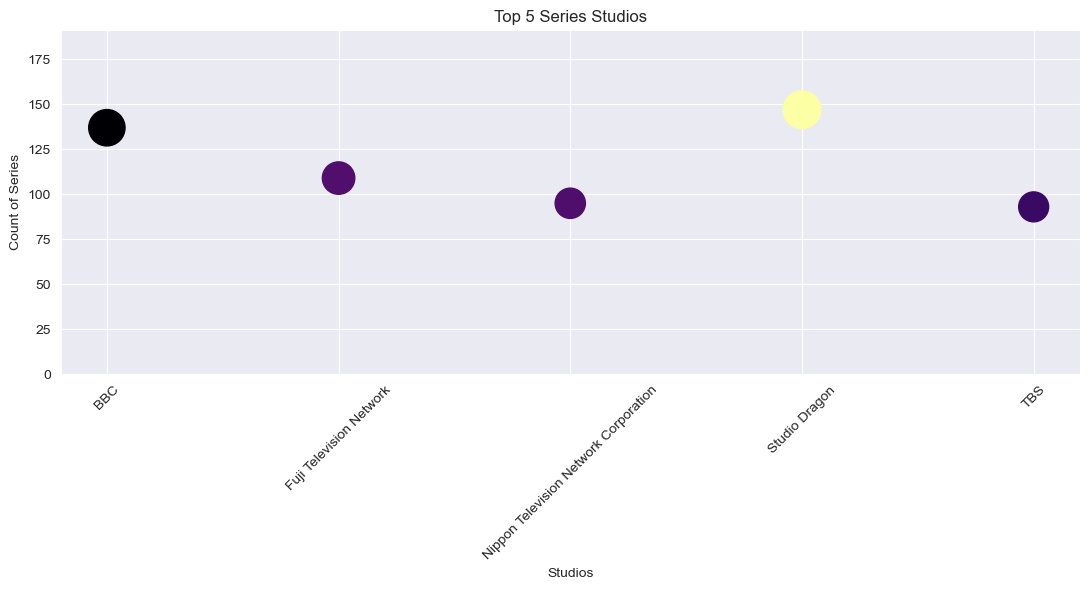

In [53]:
plt.figure(figsize=(11, 6))
plt.scatter(
    x=studio_series_duration['studio'],
    y=studio_series_duration['series_count'],
    s=studio_series_duration['series_count']*5,
    c=studio_series_duration['avg_duration'],
    cmap='inferno'
)
plt.title('Top 5 Series Studios')
plt.xticks(rotation=45)
plt.xlabel('Studios')
plt.ylabel('Count of Series')
plt.ylim(0, studio_series_duration['series_count'].max()* 1.3)
plt.tight_layout()
plt.show()

# Favorite Actors in the industry
Who are the actors that has participated the most in the film industry till now? The following chart shows us who is the actor that has this honor.  
He wins the race by far over the others, he has almost twice the film count of any other actor in the top 5, his name is Mel Blanc.  
There is an interesting fact about these names, 7 out of 10 are indians and the other 3 are americans, we can think about hundreds of actors who are American, Italian, Spanish or French, but I dare anyone who doesn't live in India to name an indian actor o actress.  
Mel Blanc was known for his voice, he is in fact the person who gave the voice to the characters of cartoons like The Looney Tunes, his nickname was The Man of a Thousand Voices

In [4]:
actor_movies = pd.merge(movies, actors, on='id', how='inner')
actor_movies.rename(columns={'name_x': 'film_name', 'name_y': 'actor_name'}, inplace=True)
actor_movies = actor_movies[(actor_movies['date'] < 2024)]
actor_movies = actor_movies[(actor_movies['actor_name'].notna()) & (actor_movies['film_name'].notna())]

In [5]:
top_10_actor_count = actor_movies.groupby('actor_name')['id'].count().sort_values(ascending=False).head(10).index
top_actor_movies = actor_movies[actor_movies['actor_name'].isin(top_10_actor_count)]
top_actor_movies_count = top_actor_movies.groupby('actor_name').agg(movie_count=('id', 'count')).reset_index()

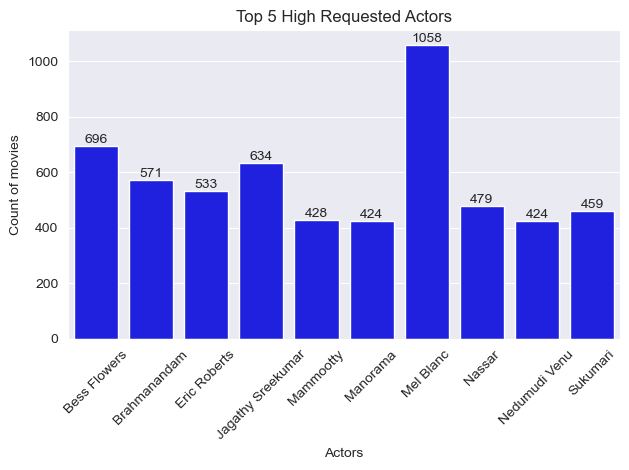

In [25]:
ax = sns.barplot(data=top_actor_movies_count, x='actor_name', y='movie_count', color='blue')
plt.title('Top 5 High Requested Actors')
plt.xlabel('Actors')
plt.ylabel('Count of movies')
plt.xticks(rotation=45)
for container in ax.containers:
    ax.bar_label(container, fmt='%.d')
plt.tight_layout()
plt.show()

# We're not done
There is, by any chance, a correlation between the quantity of movies produced and the quality of them?  
Well... no, there isn't, the quantity and the quality doesn't go hand by hand, but why? In this case I think that's because in the datasets provided there is a rating for the film, this rating affects the rating of every actor in the movie cast, so even actors with just one movie in their curriculum can have a high rating. We could see this type of correlation if we consider the main character role, but in this case we don't have it. So we can say that, in general, there is no correlation between the two categories, movie count and average rating of every actor/actress

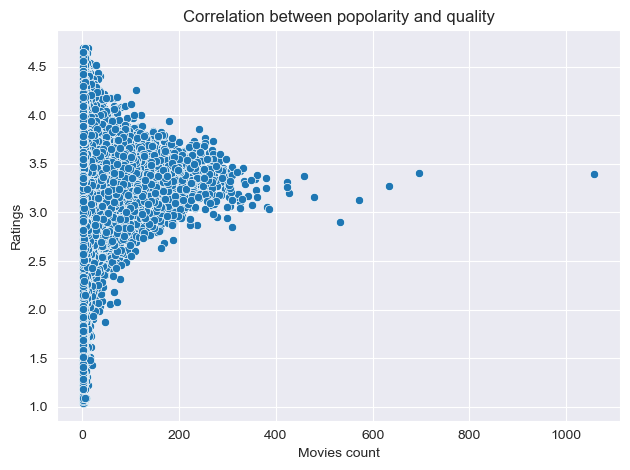

In [14]:
correlation = actor_movies.groupby('actor_name').agg(movie_count=('id', 'count'), avg_rating=('rating', 'mean')).reset_index()
sns.scatterplot(data=correlation, x='movie_count', y='avg_rating')
plt.title('Correlation between popolarity and quality')
plt.xlabel('Movies count')
plt.ylabel('Ratings')
plt.tight_layout()
plt.show()

# Critics Review and Film Rating
There must be a correlation between teh ratings of the movies and the average review score of the critics, so here we are.  
We can see that there is a big part of the movies correlated with the score review of the critics, we can ignore the outliers because in every measurement there are exceptions. The review score in the dataset are made by critics that can be considered top critics or not so this visualisation is made with both top and regular critics.  
The review score of the critics are in line with the ratings of the movies, as we can expect, but let's see if, considering only the top critics, the correlation is higher or not

In [17]:
rotten_tomatoes['normalized_review'] = rotten_tomatoes['review_score'].apply(normalize_review)
rotten_tomatoes['review_year'] = rotten_tomatoes['review_date'].dt.year

In [19]:
movies_view = movies[['id', 'name', 'date' ,'rating']]
rotten_view = rotten_tomatoes[['movie_title', 'critic_name', 'top_critic', 'review_type', 'normalized_review', 'review_year']]

In [39]:
movies_review = pd.merge(movies_view, rotten_view, left_on='name', right_on='movie_title', how='inner')
movies_review = movies_review[(movies_review['date'] < 2024) & (movies_review['rating'].notna()) & (movies_review['normalized_review'].notna()) & ((movies_review['date'] == movies_review['review_year']) | (movies_review['review_year'] == (movies_review['date'] + 1))) & (movies_review['critic_name'].notna())]

In [40]:
grouped = movies_review.groupby(['id', 'rating']).agg(avg_review=('normalized_review', 'mean')).reset_index()

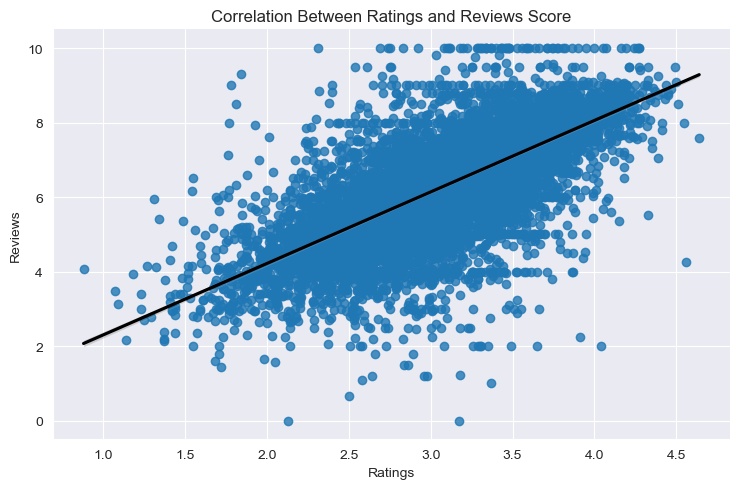

In [59]:
sns.lmplot(data=grouped, x='rating', y='avg_review', height=5, aspect=1.5, line_kws={'color': 'black'})
plt.title('Correlation Between Ratings and Reviews Score')
plt.xlabel('Ratings')
plt.ylabel('Reviews')
plt.tight_layout()
plt.show()

# Top Critics are Better?
We filtered the previous datas by keeping only the critics that are considered TOP critics and tried the same analysis, the results are the same, the correlation is almost the same as the one we have already done, so it's not important if a critic is one of the Top ones, every review score reflects, more or less, the final rating of the movie.  
So, in conclusion, we can say that yes, there is a correlation between the two variables, but this is less strong than we expected in the beginning 

In [42]:
correlation = movies_review
correlation = correlation[correlation['top_critic'] == True]
corr = correlation.groupby(['id', 'rating']).agg(avg_review=('normalized_review', 'mean')).reset_index()

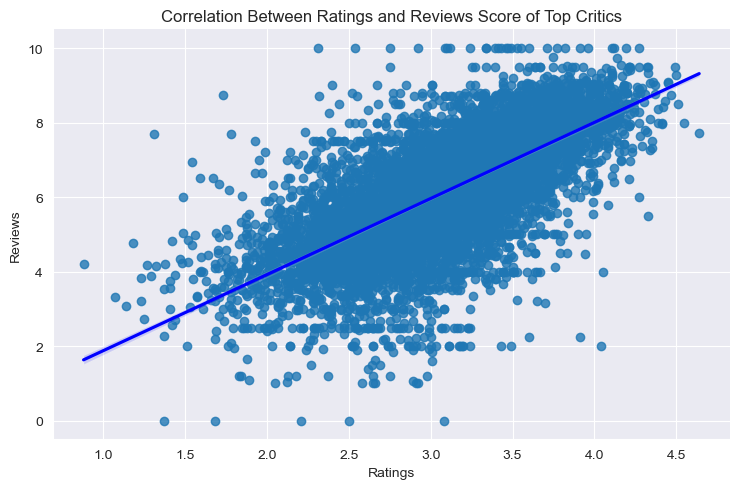

In [58]:
sns.lmplot(data=corr, x='rating', y='avg_review', height=5, aspect=1.5, line_kws={'color': 'blue'})
plt.title('Correlation Between Ratings and Reviews Score of Top Critics')
plt.xlabel('Ratings')
plt.ylabel('Reviews')
plt.tight_layout()
plt.show()